# Table of Contents

1. [Load Project](#Load-Project)
    1. [Load the HMM results](#Load-the-HMM-results)
2. [Data Stream 1: KDE](#Data-Stream-1:-Kernel-Density-Estimation-(KDE))
3. [Data Stream 2: Targeted Angle](#Data-Stream-2:-Targeted-Angle)
4. [Data Stream 3: Value-based Distance](#Data-Stream-3:-Value-based-Distance)
    1. [Spatial Embedding](#Spatial-Embedding-across-the-maze-(based-on-Value-map))
5. [Run CoMPASS Level-2](#Run-CoMPASS-Level-2)
    1. [Visualize CV results](#Visualize-CV-results)
6. [Create 4 level HHMM States](#Create-4-level-HHMM-States)
7. [Observe the raw state sequence](#Observe-the-raw-state-sequence)
8. [Observe the HHMM state sequence](#Observe-the-HHMM-state-sequence)

# Load Project

In [2]:
from pathlib import Path
import pandas as pd
from compass_labyrinth import load_project


project_path = Path(".").resolve() / "my_project_2"

# Import config and metadata
config, cohort_metadata = load_project(project_path=project_path)

### Load the HMM results

In [3]:
df_hmm = pd.read_csv(project_path / "results" / "compass_level_1" / "data_with_states.csv")
df_hmm

,ID,step,angle,x,y,Grid Number,likelihood,S_no,Region,Session,Genotype,Sex,NodeType,Velocity,HMM_State,Post_Prob_1,Post_Prob_2
0,3,3.912921,-1.149582,267.526978,873.733704,47,0.986050,750,entry_zone,3,WT,Female,Entry Nodes,19.564603,1.0,NaN,NaN
1,3,1.981172,0.620240,265.571991,873.412659,47,0.953975,751,entry_zone,3,WT,Female,Entry Nodes,9.905860,1.0,NaN,NaN
2,3,1.066163,-2.518697,266.325684,874.166748,47,0.958631,752,entry_zone,3,WT,Female,Entry Nodes,5.330815,1.0,NaN,NaN
3,3,0.899351,2.238799,265.432495,874.271851,47,0.932229,753,entry_zone,3,WT,Female,Entry Nodes,4.496755,1.0,NaN,NaN
4,3,0.519677,1.625876,265.400269,873.753174,47,0.909978,754,entry_zone,3,WT,Female,Entry Nodes,2.598385,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265485,7,58.644322,-0.866077,228.690262,814.897949,34,0.999385,225311,reward_path,7,KO,Female,Non-Decision (Reward),293.221609,2.0,NaN,NaN
265486,7,67.785952,0.178698,292.517883,837.722717,46,0.999992,225312,entry_zone,7,KO,Female,Entry Nodes,338.929760,2.0,NaN,NaN
265487,7,24.729589,1.114421,295.305054,862.294739,47,0.999458,225313,entry_zone,7,KO,Female,Entry Nodes,123.647944,2.0,NaN,NaN
265488,7,14.627917,0.109074,295.361694,876.922546,47,0.999976,225314,entry_zone,7,KO,Female,Entry Nodes,73.139586,2.0,NaN,NaN


# Data Stream 1: Kernel Density Estimation (KDE)

This workflow optimizes and applies kernel density estimation (KDE) to spatial navigation data using Leave-One-Session-Out (LOSO) cross-validation. It selects the best spatial smoothing parameter (sigma), computes session-wise KDE values, and visualizes the resulting density maps.

In [4]:
from compass_labyrinth.compass.level_2 import (
    loso_kde_cv,
    compute_kde_scaled,
)


# Define bandwidth search space
smoothing_factors = [0.5, 2, 4]

# Run LOSO CV to get best sigma
best_sigma = loso_kde_cv(df_hmm, smoothing_factors)

# Compute KDE using optimal sigma
df_hmm = compute_kde_scaled(df_hmm, best_sigma)

Testing for sigma =  0.5
Testing for sigma =  2
Testing for sigma =  4
Best Sigma =  0.5
Computing KDE for Session 3...
Computing KDE for Session 4...
Computing KDE for Session 5...
Computing KDE for Session 6...
Computing KDE for Session 7...


# Data Stream 2: Targeted Angle

This workflow computes the angular deviation of the animal's movement from a defined reference axis for each grid location in the maze. It incorporates spatial smoothing by mapping each grid to a reference node, calculates mean node positions, and derives angular deviation vectors session-wise.

In [5]:
from compass_labyrinth.compass.level_2 import (
    assign_reference_info,
    compute_angle_deviation,
)


ROLLING_WINDOW = 5

# Reference Info
df_hmm = assign_reference_info(df_hmm)

# Compute angle deviation
df_hmm = compute_angle_deviation(df_hmm, rolling_window=ROLLING_WINDOW)

# Data Stream 3: Value-based Distance

This workflow computes a normalized, value-weighted distance of each animal position from a central target region (e.g., Grid 84 and 85). This metric can be used to quantify how spatially aligned behavior is with goal-relevant zones.

In [6]:
from compass_labyrinth.compass.level_2 import compute_value_distance


# Run the value distance computation pipeline
df_hmm = compute_value_distance(df_hmm, center_grids=[84, 85])

## Spatial Embedding across the maze (based on Value-map)

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/spatial_embedding_heatmap.pdf


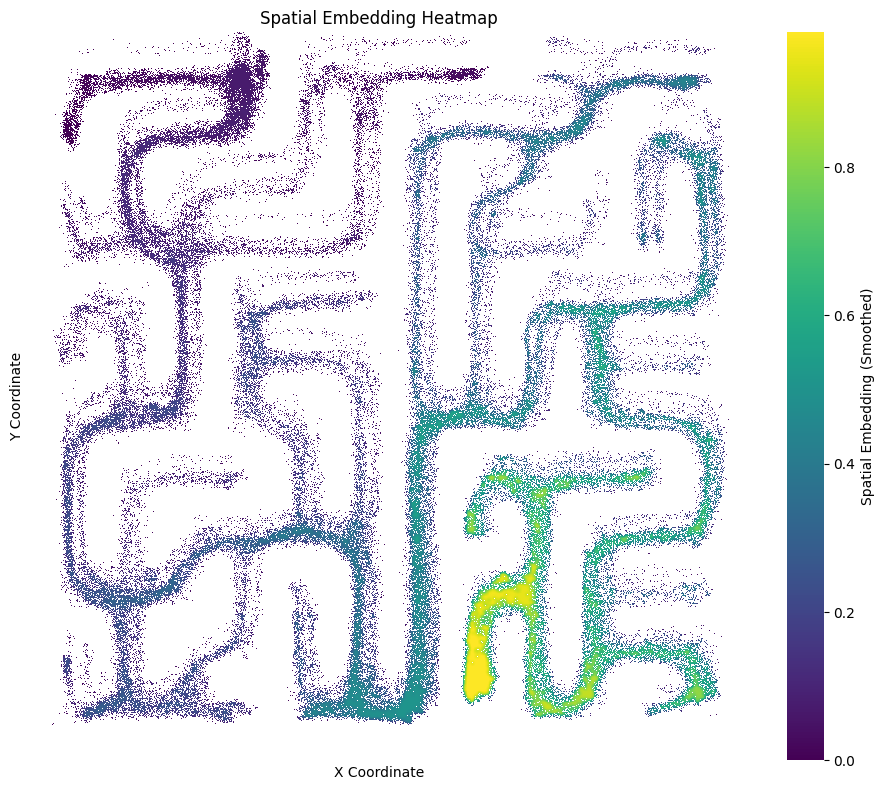

In [7]:
from compass_labyrinth.compass.level_2 import (
    compute_spatial_embedding,
    create_embedding_grid,
    plot_spatial_embedding,
)


# Compute Smoothed Spatial Embedding
# Apply spatial smoothing over the dataframe using a Gaussian kernel (sigma = 2)
# This function generates a local average of behavioral or positional metrics
df_smoothed = compute_spatial_embedding(df_hmm, sigma=2)

# Convert Smoothed Data to Grid Format
embedding_grid = create_embedding_grid(df_smoothed)

# Visualize Spatial Embedding as Heatmap
# Plot a heatmap of the smoothed behavioral embedding
plot_spatial_embedding(
    config=config,
    embedding_grid=embedding_grid,
)

# Run CoMPASS Level-2

In [8]:
from compass_labyrinth.compass.level_2 import run_compass


features = ['HMM_State','VB_Distance','Targeted_Angle_smooth_abs','KDE']

df_hier, cv_results = run_compass(
    config=config,
    df=df_hmm,
    features=features,
    phase_options=[5],                 # different phase options can be tested out
    ncomp_options=[2, 3],
    k_options=[2, 3],
    reg_options=[1e-4, 1e-5, 1e-6],
    terminal_values=[47],              # entry node --> starting point
    bout_col='Bout_ID',
    patience=None,
    patience_candidates=[2, 3, 5, 10]  # (only used if patience == 'tune')
)


=== CV | Test: Session 3 - Phase 1/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 32802.802904054675 is not greater than 171976.91901323298. Delta is -139174.1161091783
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not conve


=== CV | Test: Session 4 - Phase 1/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 32802.802904054675 is not greater than 171976.91901323298. Delta is -139174.1161091783
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not conve


=== CV | Test: Session 5 - Phase 1/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 34390.86259483184 is not greater than 70423.34389455612. Delta is -36032.481299724284
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not conver


=== CV | Test: Session 6 - Phase 1/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 25991.47718456559 is not greater than 37837.38489610907. Delta is -11845.907711543481
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' a


=== CV | Test: Session 7 - Phase 1/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 101586.19030817584 is not greater than 107007.40509059535. Delta is -5421.214782419513
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' 


=== CV | Test: Session 3 - Phase 2/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 47667.954166965945 is not greater than 63522.23384879238. Delta is -15854.279681826432
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not conve


=== CV | Test: Session 4 - Phase 2/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 47667.954166693955 is not greater than 63522.233851509554. Delta is -15854.2796848156
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not conver


=== CV | Test: Session 5 - Phase 2/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Covariance of state #0, 


=== CV | Test: Session 6 - Phase 2/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 56127.521964080785 is not greater than 86418.94954951014. Delta is -30291.42758542936
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' a


=== CV | Test: Session 7 - Phase 2/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 99801.24731761876 is not greater than 153727.72979051055. Delta is -53926.48247289179
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' a


=== CV | Test: Session 3 - Phase 3/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is s


=== CV | Test: Session 4 - Phase 3/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is s


=== CV | Test: Session 5 - Phase 3/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Covariance of state #0, 


=== CV | Test: Session 6 - Phase 3/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is s


=== CV | Test: Session 7 - Phase 3/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 108701.44432585449 is not greater than 346525.16289942747. Delta is -237823.718573573
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' a


=== CV | Test: Session 3 - Phase 4/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attrib


=== CV | Test: Session 4 - Phase 4/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attrib


=== CV | Test: Session 5 - Phase 4/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 13789.547596277827 is not greater than 77087.69357452846. Delta is -63298.14597825063
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not conver


=== CV | Test: Session 6 - Phase 4/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 27582.637833085755 is not greater than 27775.360092804825. Delta is -192.72225971907028
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_'


=== CV | Test: Session 7 - Phase 4/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 61705.916157824795 is not greater than 124519.52202176469. Delta is -62813.60586393989
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' 


=== CV | Test: Session 3 - Phase 5/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 7258.194359370815 is not greater than 22981.57324476606. Delta is -15723.378885395245
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not conver


=== CV | Test: Session 4 - Phase 5/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 7258.194358707974 is not greater than 22981.57324404553. Delta is -15723.378885337555
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not conver


=== CV | Test: Session 5 - Phase 5/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 101521.69597187224 is not greater than 375048.6771932868. Delta is -273526.9812214146
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #0, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute


=== CV | Test: Session 6 - Phase 5/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: -11629.864503030338 is not greater than -8266.67092270791. Delta is -3363.193580322428
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not conve


=== CV | Test: Session 7 - Phase 5/5 ===


Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Covariance of state #0, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #0 has a null eigenvalue.
Covariance of state #1, mixture #1 has a null eigenvalue.
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attrib

HHMM state file saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/csvs/combined/hhmm_state_file.csv


### Visualize CV results

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-3_PhaseIndex-1_NumPhases-5_Patience-None.pdf


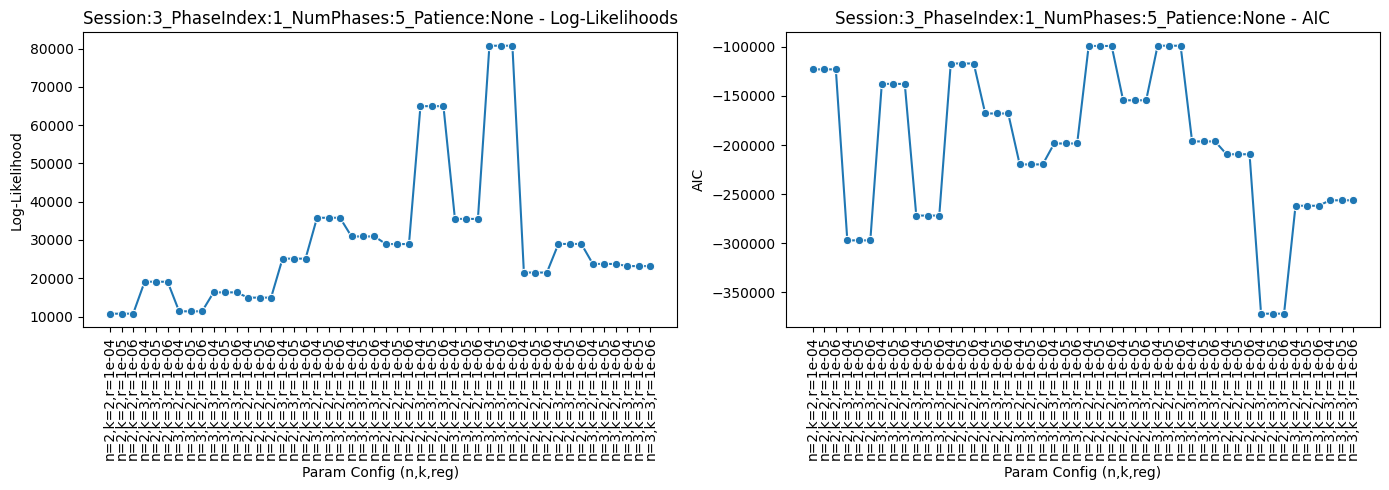

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-4_PhaseIndex-1_NumPhases-5_Patience-None.pdf


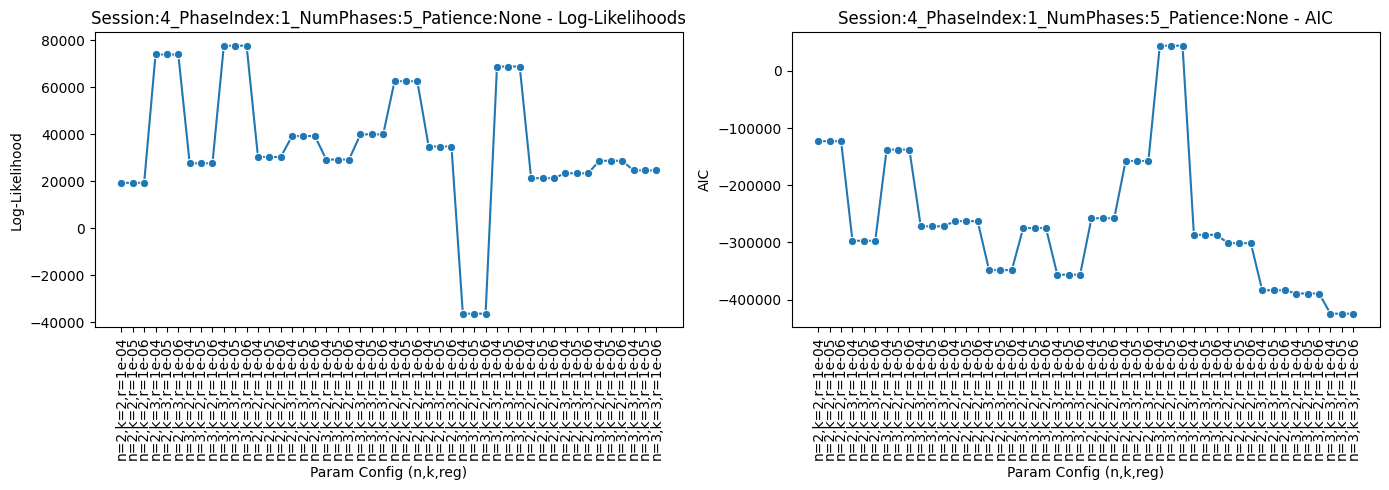

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-5_PhaseIndex-1_NumPhases-5_Patience-None.pdf


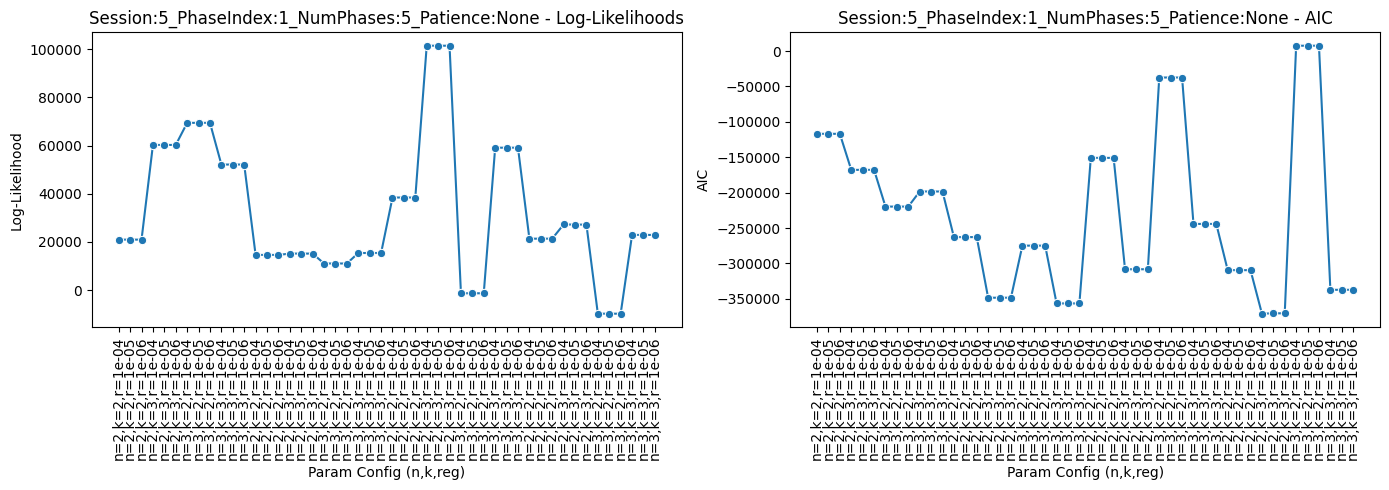

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-6_PhaseIndex-1_NumPhases-5_Patience-None.pdf


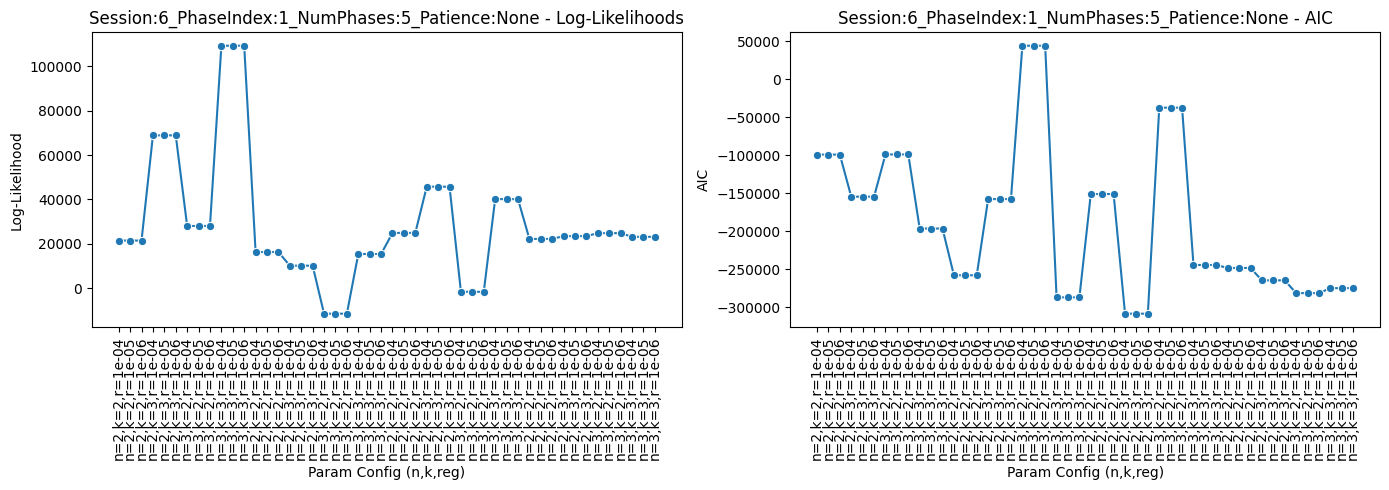

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-7_PhaseIndex-1_NumPhases-5_Patience-None.pdf


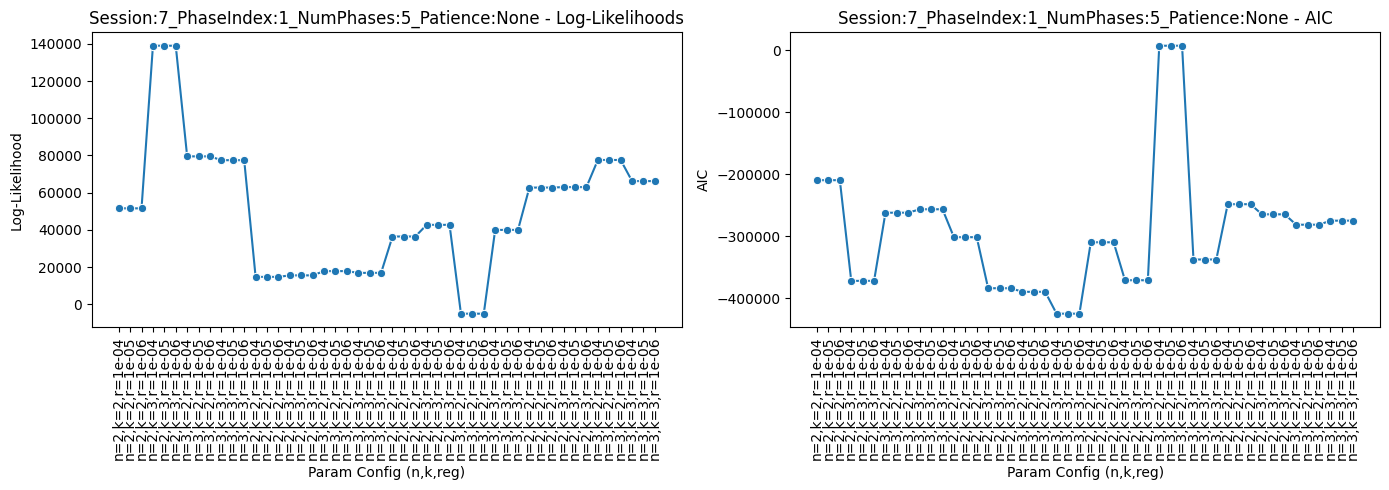

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-3_PhaseIndex-2_NumPhases-5_Patience-None.pdf


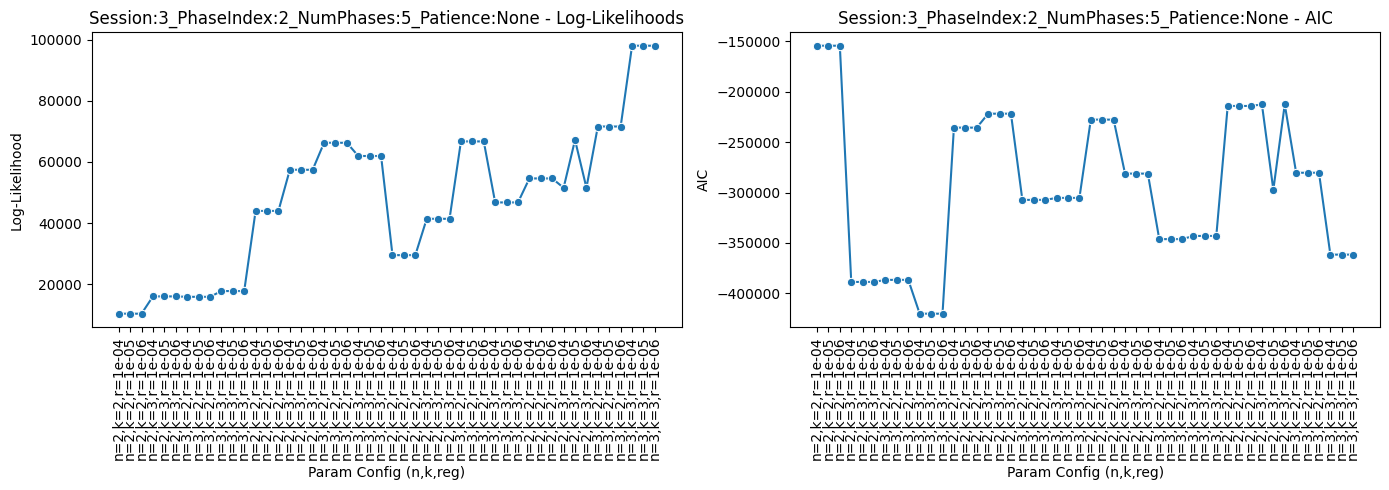

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-4_PhaseIndex-2_NumPhases-5_Patience-None.pdf


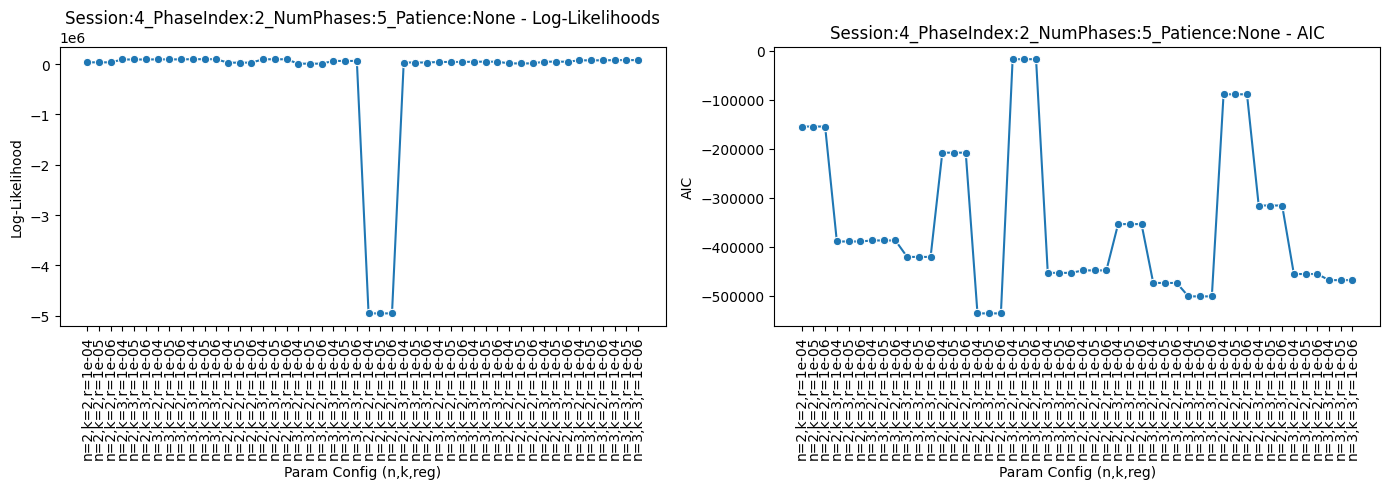

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-5_PhaseIndex-2_NumPhases-5_Patience-None.pdf


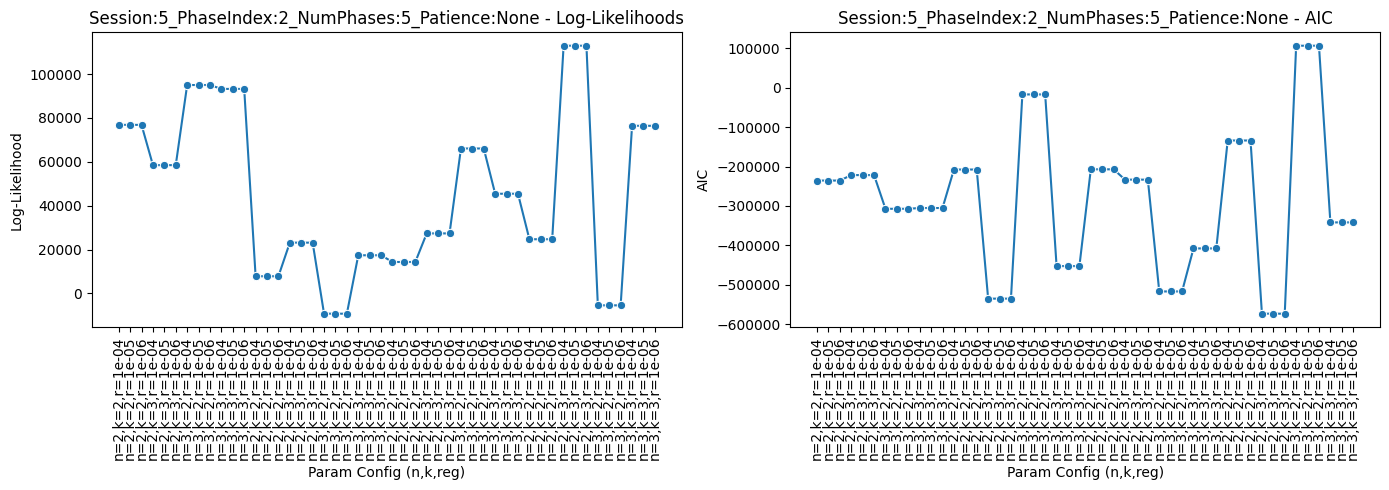

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-6_PhaseIndex-2_NumPhases-5_Patience-None.pdf


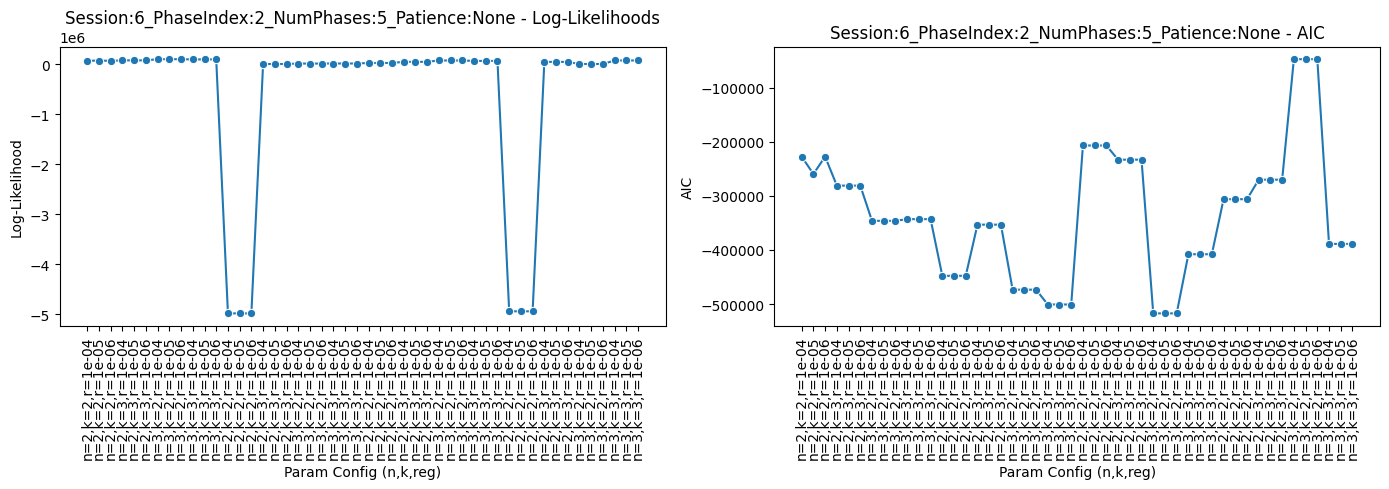

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-7_PhaseIndex-2_NumPhases-5_Patience-None.pdf


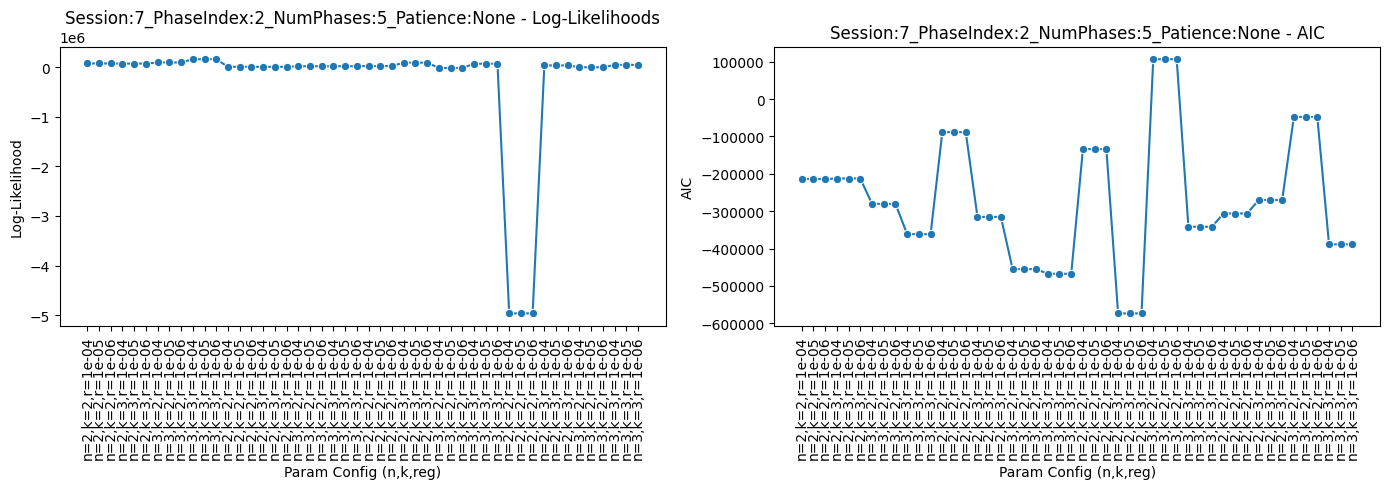

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-3_PhaseIndex-3_NumPhases-5_Patience-None.pdf


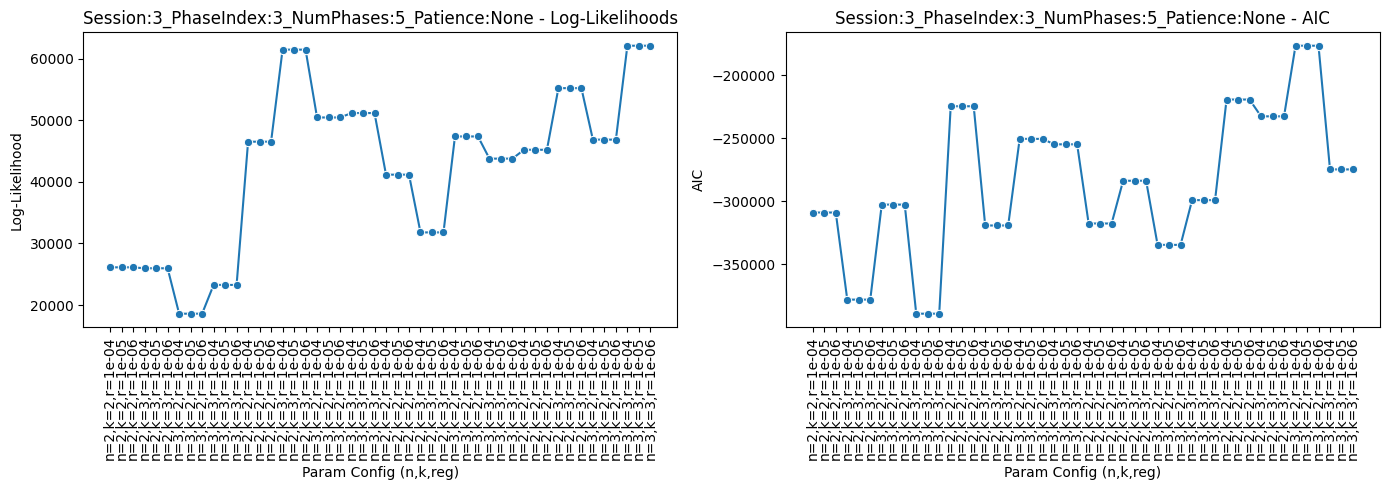

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-4_PhaseIndex-3_NumPhases-5_Patience-None.pdf


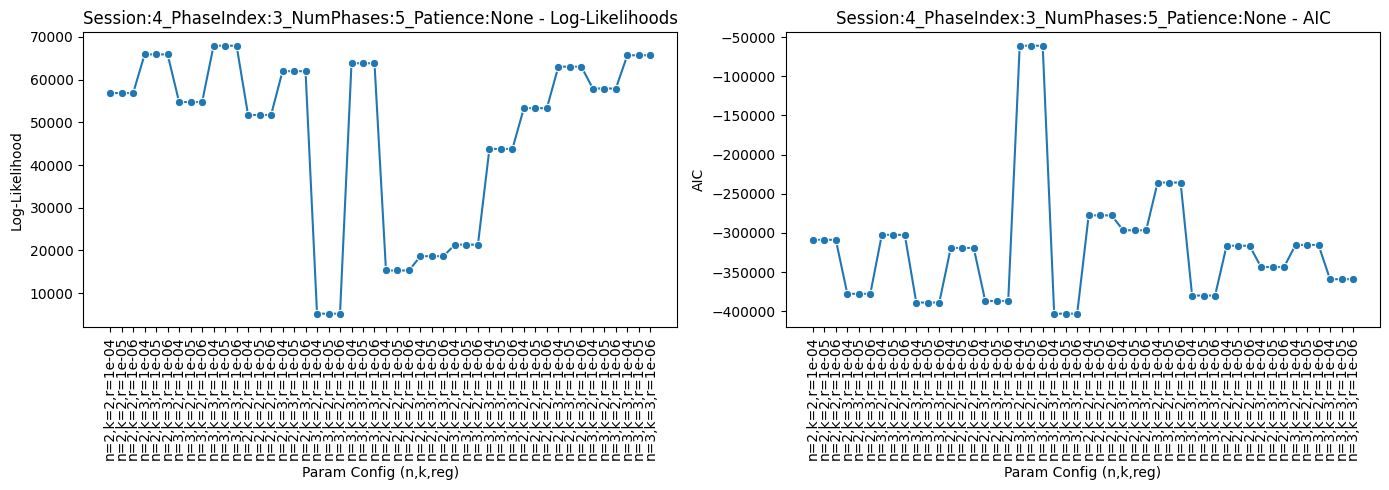

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-5_PhaseIndex-3_NumPhases-5_Patience-None.pdf


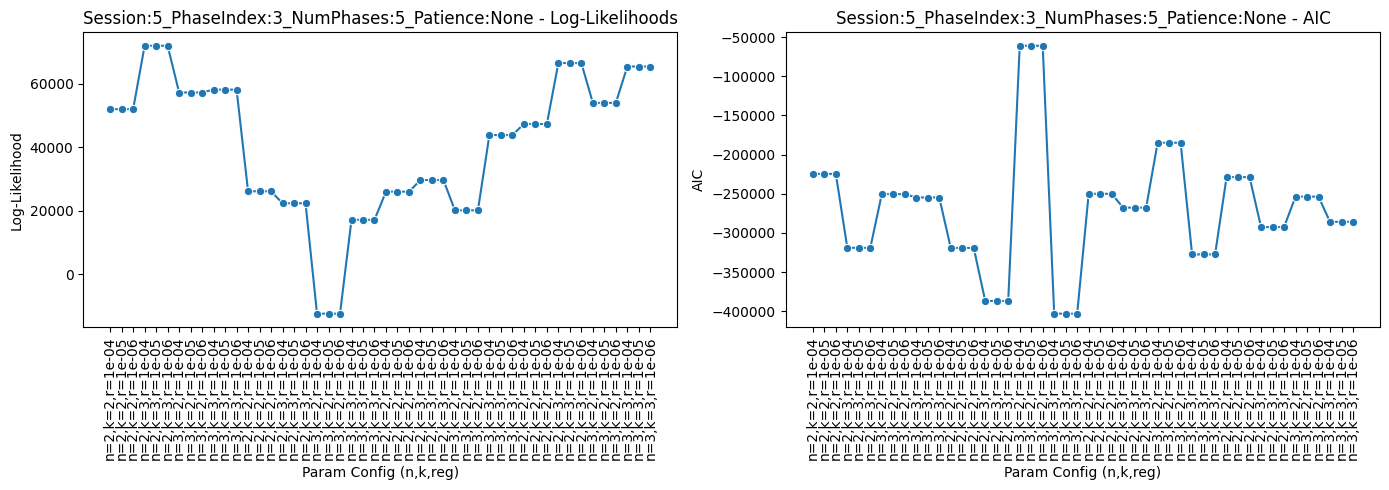

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-6_PhaseIndex-3_NumPhases-5_Patience-None.pdf


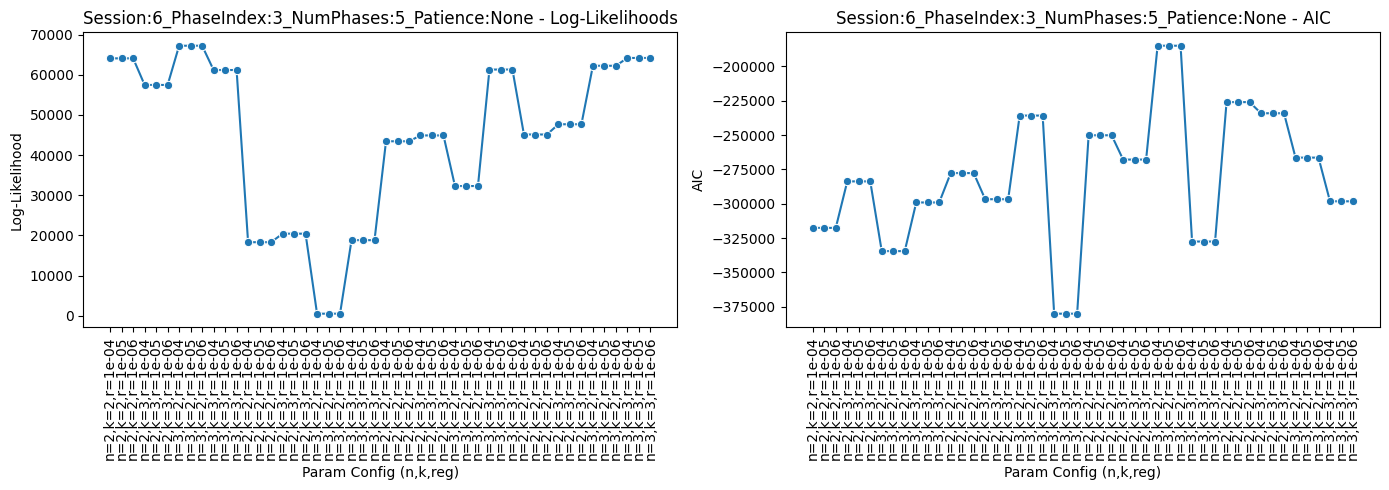

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-7_PhaseIndex-3_NumPhases-5_Patience-None.pdf


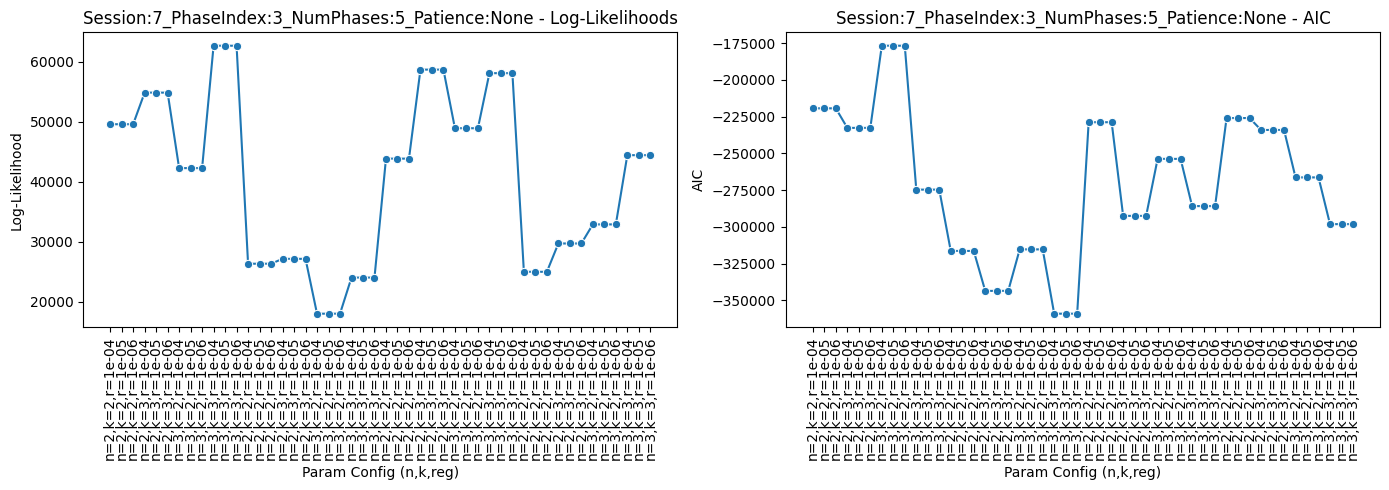

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-3_PhaseIndex-4_NumPhases-5_Patience-None.pdf


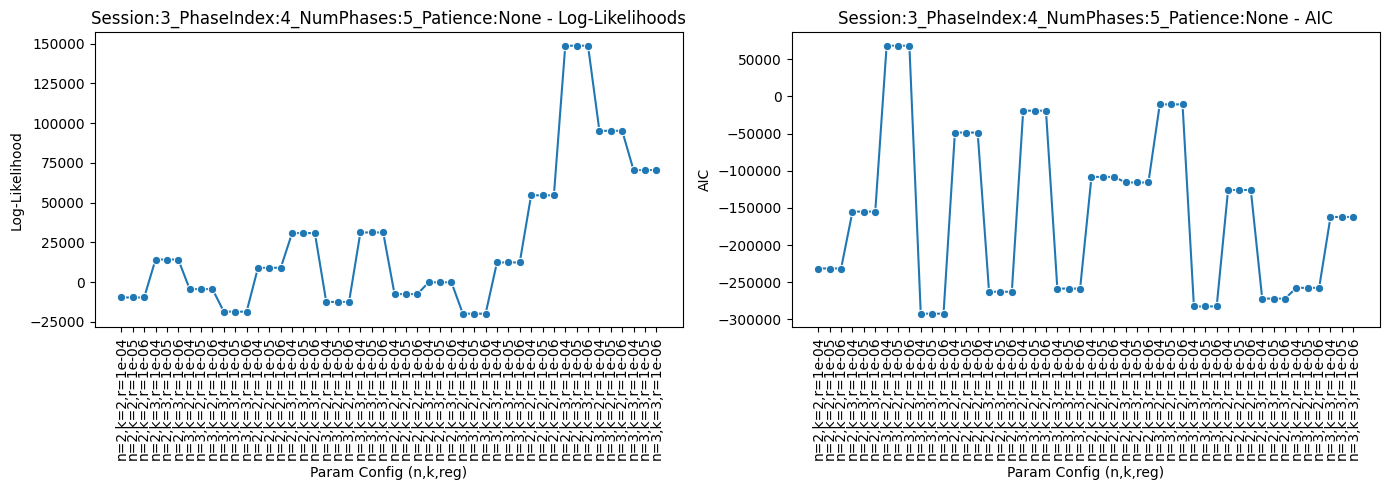

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-4_PhaseIndex-4_NumPhases-5_Patience-None.pdf


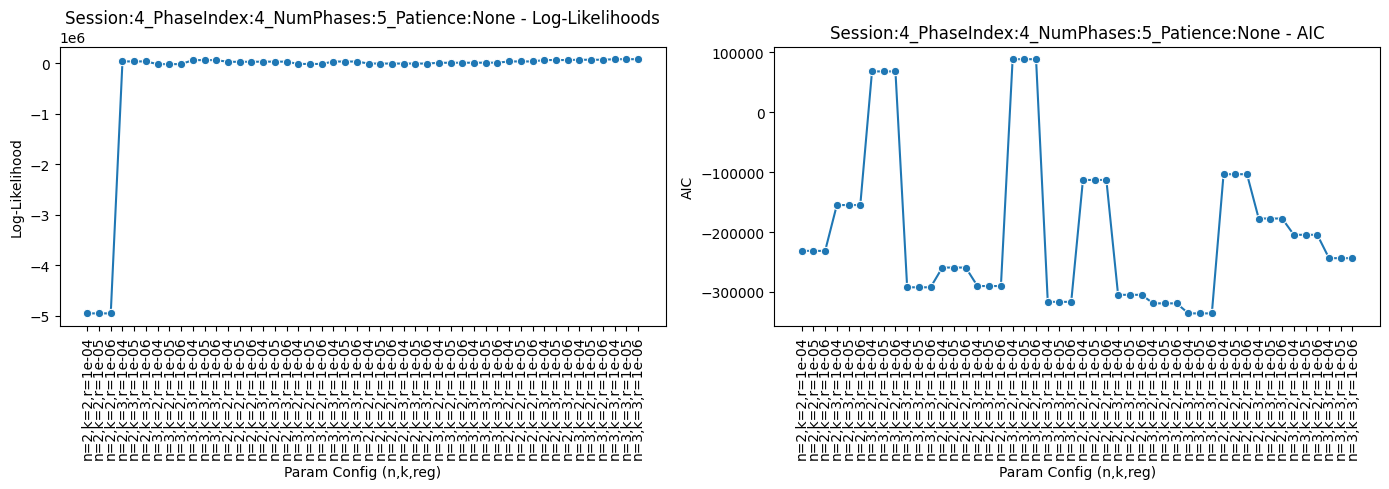

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-5_PhaseIndex-4_NumPhases-5_Patience-None.pdf


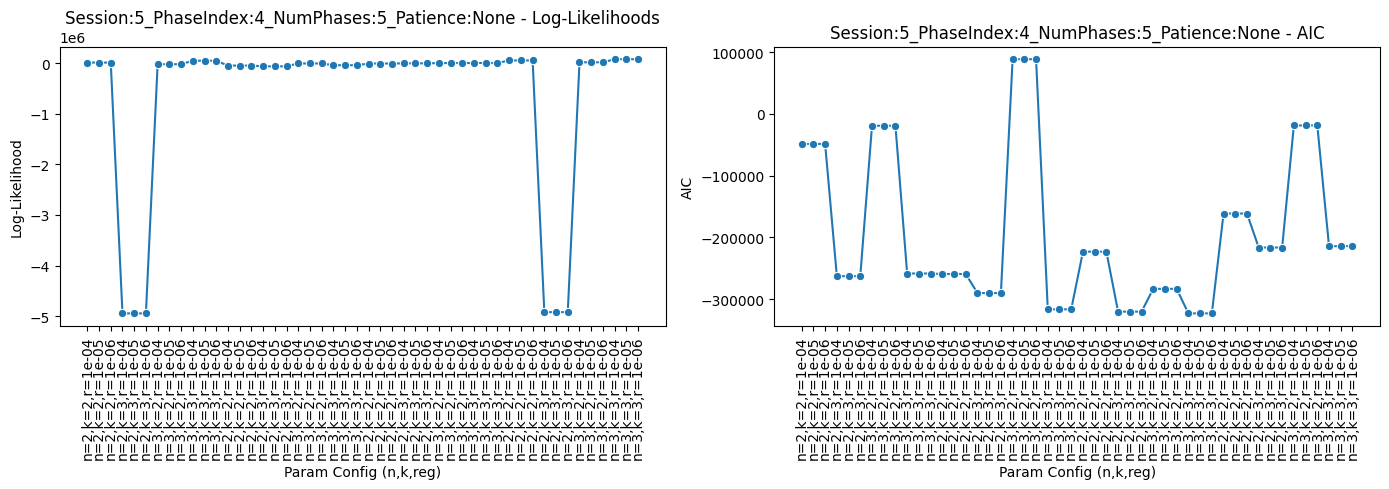

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-6_PhaseIndex-4_NumPhases-5_Patience-None.pdf


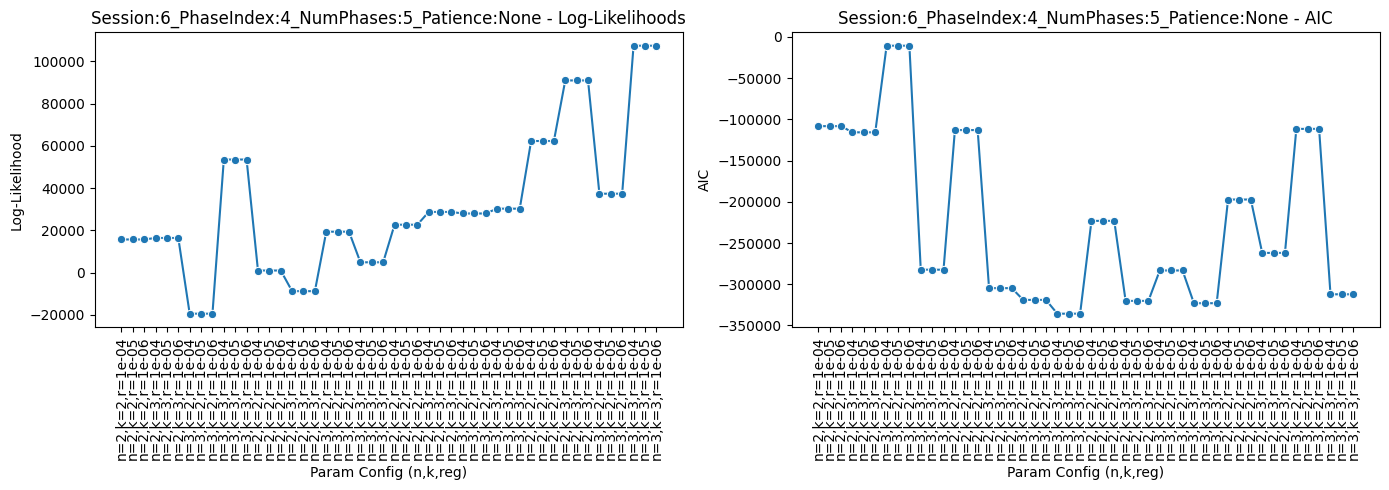

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-7_PhaseIndex-4_NumPhases-5_Patience-None.pdf


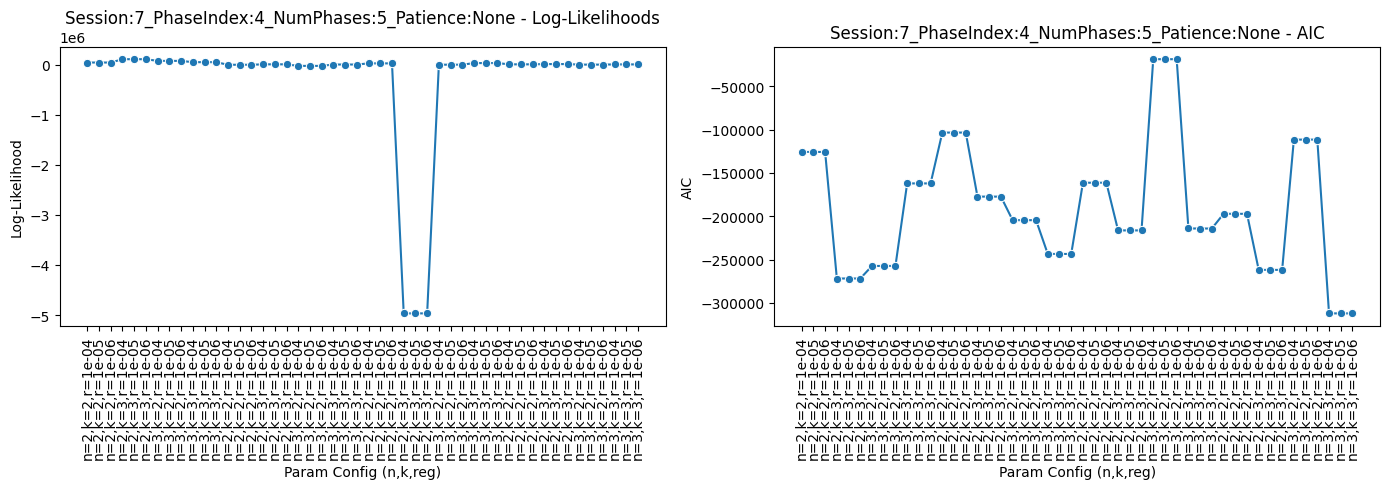

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-3_PhaseIndex-5_NumPhases-5_Patience-None.pdf


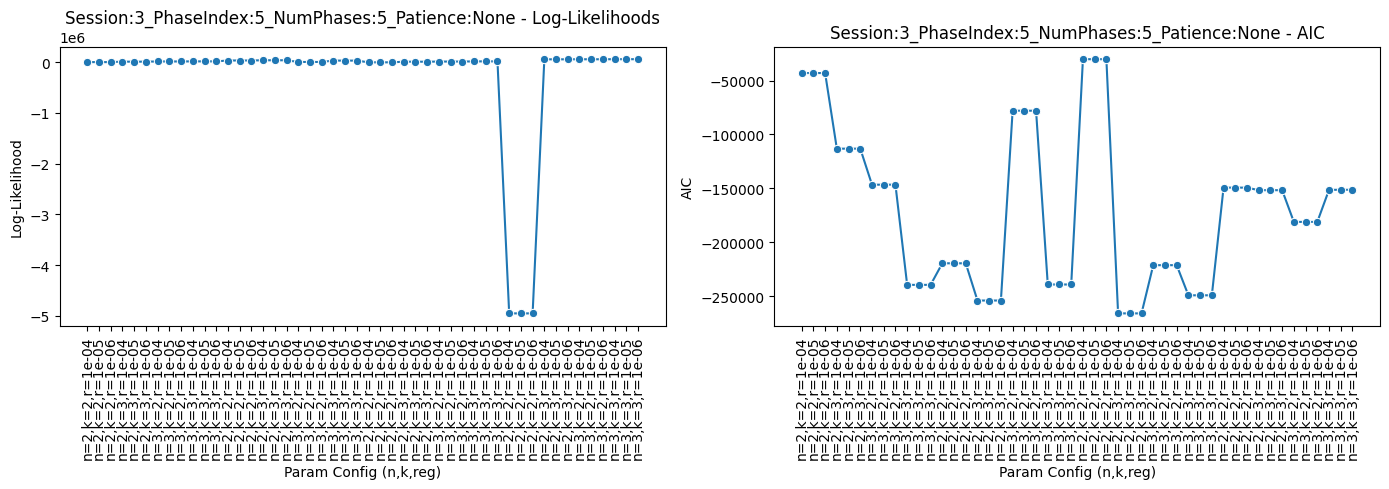

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-4_PhaseIndex-5_NumPhases-5_Patience-None.pdf


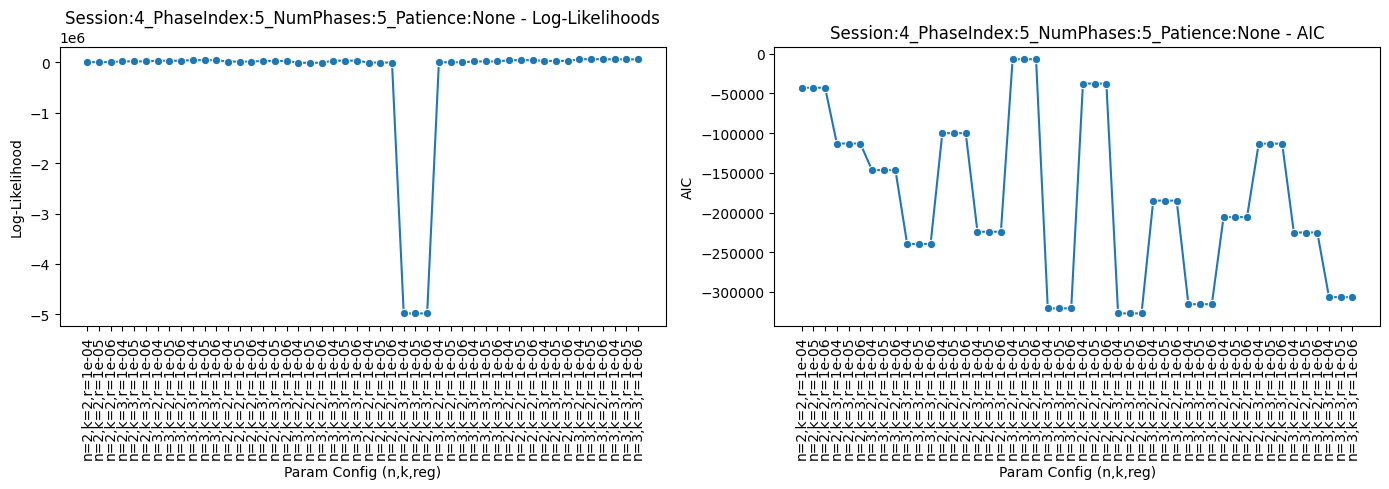

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-5_PhaseIndex-5_NumPhases-5_Patience-None.pdf


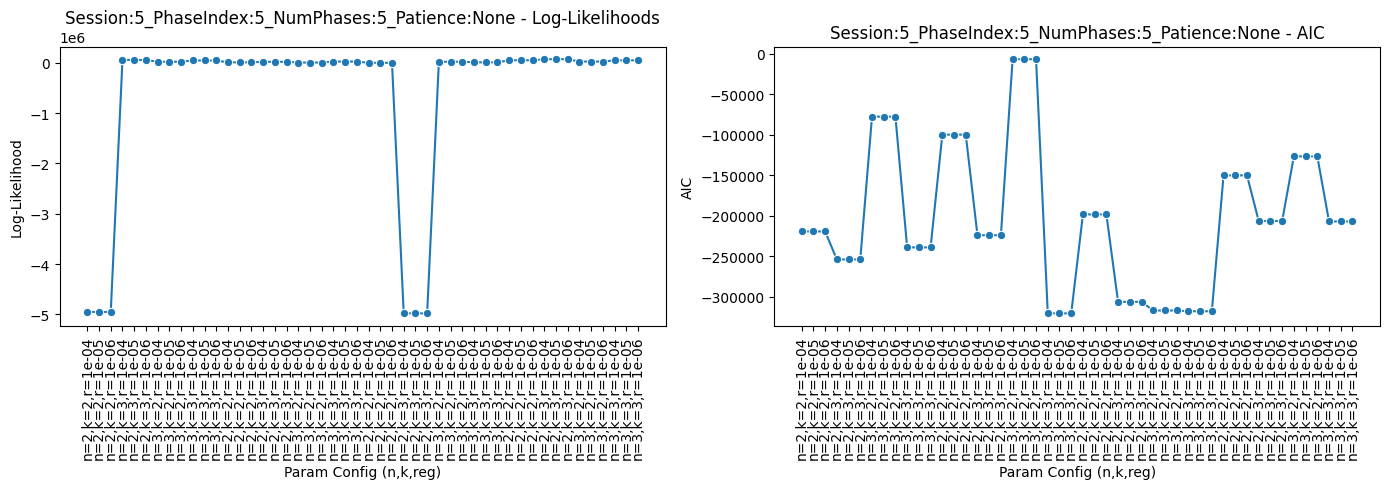

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-6_PhaseIndex-5_NumPhases-5_Patience-None.pdf


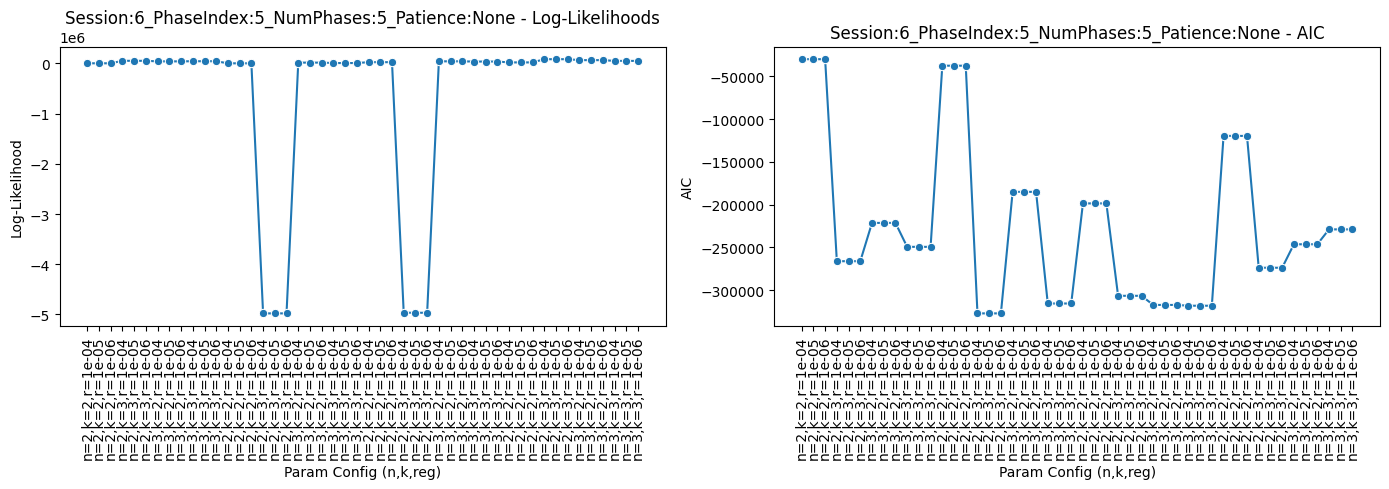

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/level_2_cv_performance_Session-7_PhaseIndex-5_NumPhases-5_Patience-None.pdf


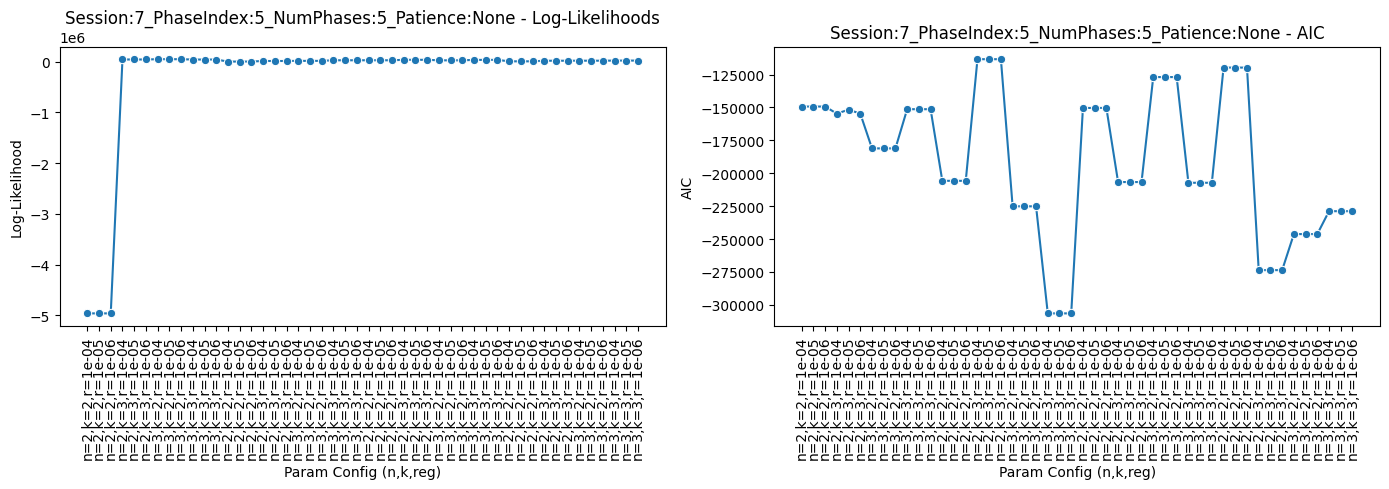

In [9]:
from compass_labyrinth.compass.level_2 import visualize_cv_results


visualize_cv_results(
    config=config,
    all_results=cv_results,
)

# Create 4 level HHMM States

In [10]:
from compass_labyrinth.compass.level_2 import (
    assign_reward_orientation,    
    assign_hhmm_state,
)

# Assign reward orientation based on session-specific angle medians
df_hier = assign_reward_orientation(
    df_hier,
    angle_col='Targeted_Angle_smooth_abs',
    level_2_state_col='Level_2_States',
    session_col='Session',
)

# Then assign the final HHMM state
df_hier = assign_hhmm_state(
    df_hier,
    level_1_state_col='HMM_State',
    level_2_state_col='Reward_Oriented',
)

/Users/luiztauffer/Github/CoMPASS-Labyrinth/src/compass_labyrinth/compass/level_2/model.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Reward Oriented' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df[session_col] == sess) & (df[level_2_state_col] == reward_state), "Reward_Oriented"] = (


# Observe the raw state sequence

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/state_sequence_session_3.pdf


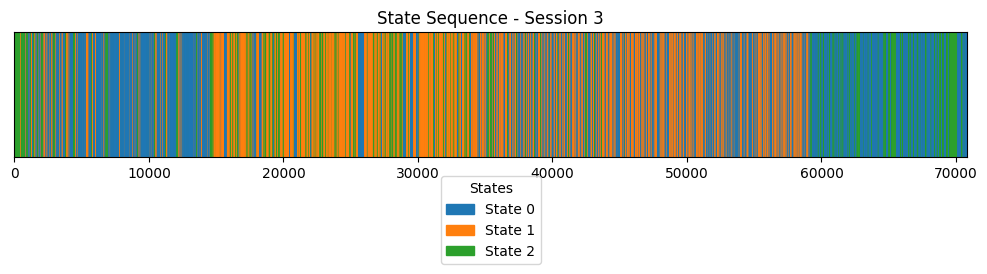

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/state_sequence_session_4.pdf


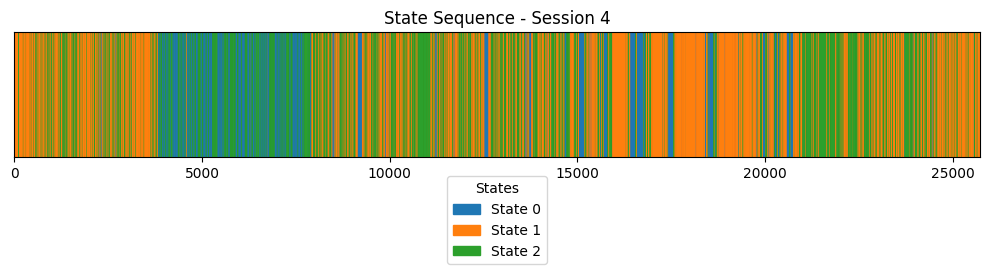

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/state_sequence_session_5.pdf


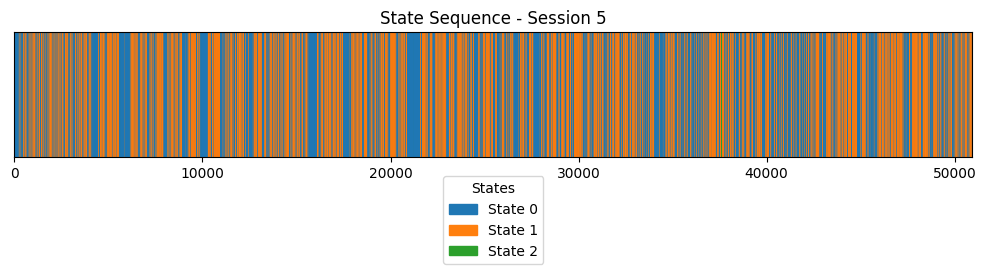

In [11]:
from compass_labyrinth.compass.level_2 import plot_state_sequences


# Plot all sessions
plot_state_sequences(
    config=config,
    df=df_hier,     
    genotype='WT',
    state_col='Level_2_States',
    sessions_to_plot='all',
    title_prefix='State Sequence',
)

# Observe the HHMM state sequence

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/hhmm_state_sequence_session_3.pdf


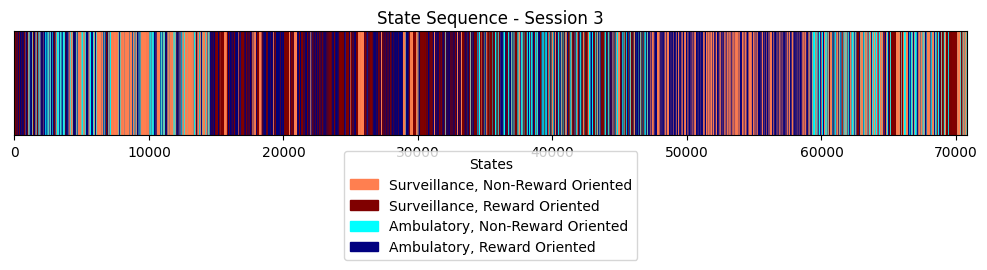

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/hhmm_state_sequence_session_4.pdf


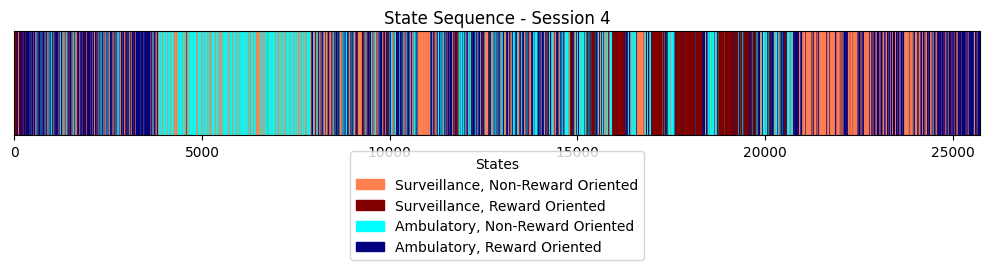

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/hhmm_state_sequence_session_5.pdf


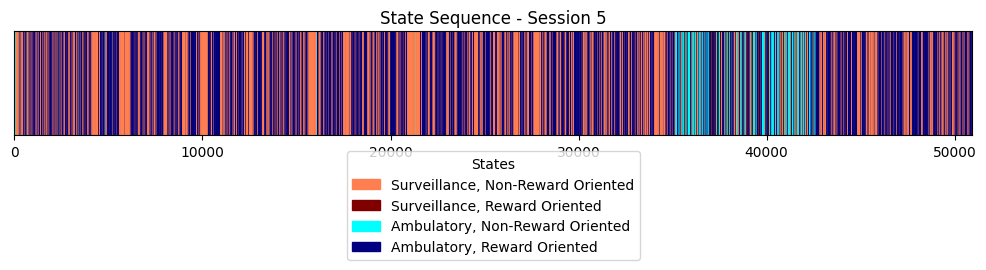

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/hhmm_state_sequence_session_6.pdf


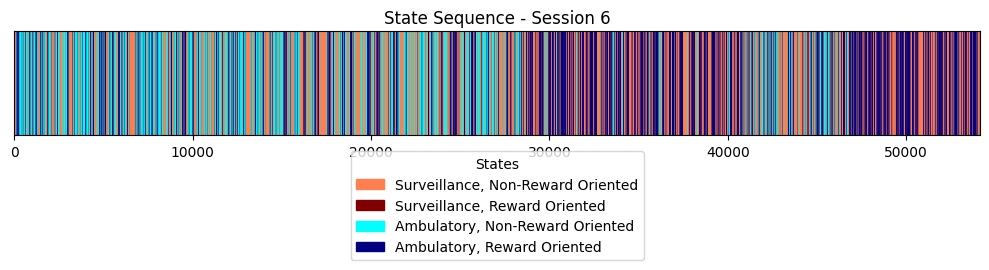

Figure saved at: /Users/luiztauffer/Github/CoMPASS-Labyrinth/notebooks/my_project_2/figures/hhmm_state_sequence_session_7.pdf


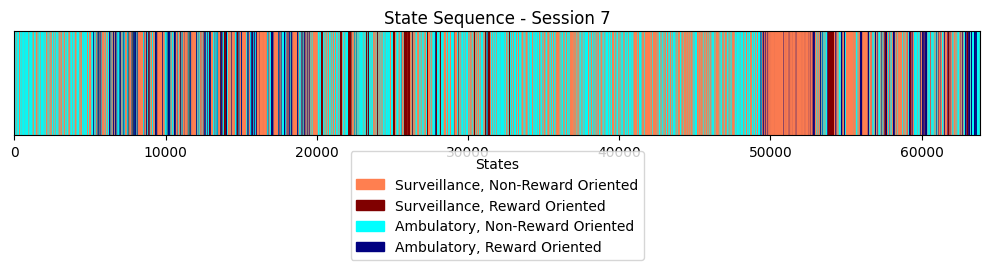

In [12]:
from compass_labyrinth.compass.level_2 import plot_hhmm_state_sequence


colors = {
    'Surveillance, Non-Reward Oriented': 'coral',
    'Surveillance, Reward Oriented': 'maroon',
    'Ambulatory, Non-Reward Oriented': 'cyan',
    'Ambulatory, Reward Oriented': 'navy',
}

# Plot HHMM state sequences for all sessions
plot_hhmm_state_sequence(
    config=config,
    df=df_hier,
    session_col='Session',
    state_col='HHMM State',
    colors=colors,
)